# Mise en oeuvre du filtre de Kalman étendu

## Groupe : Hadrien SALEM - Emilie SALEM

In [9]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Récupération des données

In [23]:
data = pd.read_excel(r'donnee.xlsx')

t = data["Temps"].values
y = data["signalReel"].values 
z = data["signalBruite"].values

Q = np.array([[2e-5, 0], [0, 2e-1]])
A = np.eye(2)
R = 3

Te = 1/129.28 # s


## Affichage des 300 premières valeurs du dataset

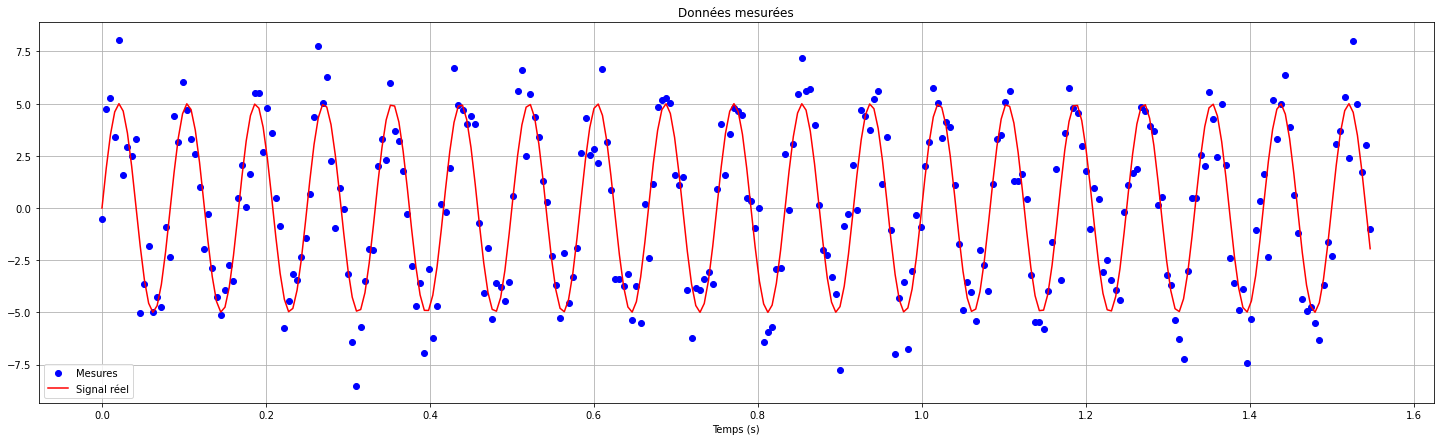

In [33]:
nb_valeurs = 300

plt.figure(figsize=(25,7))
plt.plot(t[:nb_valeurs], z[:nb_valeurs], 'bo')
plt.plot(t[:nb_valeurs], y[:nb_valeurs], 'r')
plt.title('Données mesurées')
plt.xlabel('Temps (s)')
plt.legend(["Mesures", "Signal réel"])
plt.grid()
plt.show()

## Implémentation de l'algorithme

In [42]:
m0 = ... # mean measure
gamma0 = ... # covariance matrix
nu0 = ...
h = ...
H = ...

def extended_kalman(z, m0, gamma0, h, H):
    # Initialization
    N = len(z)
    x = np.zeros(shape = (N, 2))
    P = np.array([np.zeros(shape = (2, 2)) for _ in range(N)])
    
    x[0] = m0
    P[0] = gamma0
    
    # Loop
    for k in range(0, N):
        S = H(x[k]).dot(P[k]).dot(H(x[k]).T) + R
        K = P[k].dot(H(x[k]).T)/S
        epsilon = z[k] - h(x[k])
        x[k] = x[k] + K*epsilon
        P[k] = P[k] - K.dot(H(x[k])).dot(P[k])
        
        x[k+1] = x[k]
        P[k+1] = P[k] + Q
        
    return x

array([[ 2.63599919, -1.42708534],
       [ 1.59229461, -0.74006078]])